In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import SelectKBest, f_regression, RFE

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import acquire
import prep
import modeling

# Wrangle Zillow Data

In [2]:
original_data = acquire.acquire_zillow()
df, X_train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test = prep.wrangle_zillow_1()
X_train_exp.shape

(11778, 14)

# Tax Rate Distribution by Locality

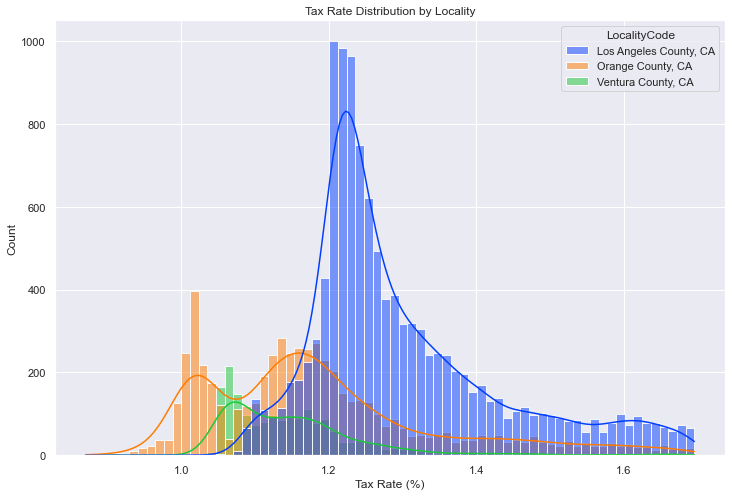

In [3]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=df, x='TaxRate', hue='LocalityCode', palette='bright', kde=True)
plt.title('Tax Rate Distribution by Locality')
plt.xlabel('Tax Rate (%)')
plt.show()

# Hypothesis Testing

In [4]:
# Function for easy printing
def significant(alpha, truth, p):
    if p < alpha and truth:
        print("Hypothesis is true with 95% confidence")
    else:
        print("Hypothesis did not pass 95% confidence threshold")

### MVP Hypothesis #1: 
There is a linear relationship between a home's value and the number of bedrooms it has.

In [5]:
# Spearman test to determine correlation between Worth and Beds

alpha = .05
corr, p = stats.spearmanr(df.dropna().Worth, df.dropna().Beds)
truth = True # no truth determination for spearman correlation test

significant(alpha, truth, p)

Hypothesis is true with 95% confidence


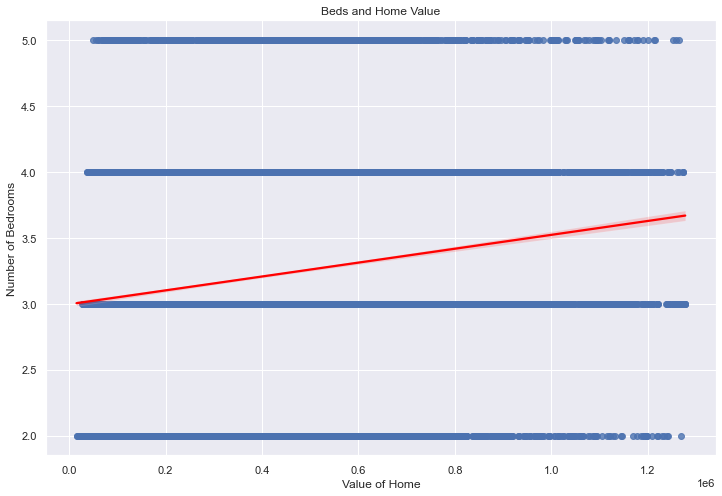

In [6]:
sns.regplot(df.Worth, df.Beds, line_kws={'color':'red'})
plt.title('Beds and Home Value')
plt.xlabel('Value of Home')
plt.ylabel('Number of Bedrooms')
plt.show()

### MVP Hypothesis #2: 
The value of a home with two bedrooms is not statistically different from a home with two bathrooms.

In [7]:
# Mannwhitney test to determine statistical difference between 
# Worth of homes with 2 Beds and Worth of homes with 2 Baths

t, p = stats.mannwhitneyu(df[df.Beds == 2].Worth, 
                          df[df.Baths == 2].Worth) 

if p > alpha and t != 0: # Note: hypothesis is that there *isn't* a statistical difference
    print("Hypothesis is true with 95% confidence")
else:
    print("Hypothesis did not pass 95% confidence threshold")

Hypothesis did not pass 95% confidence threshold


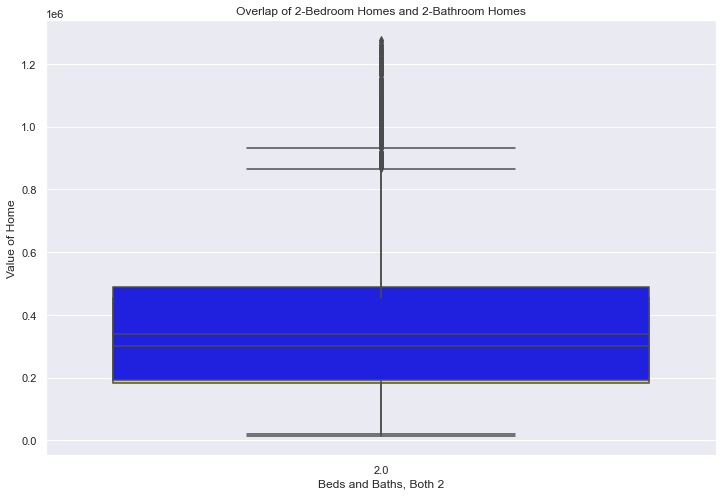

In [8]:
sns.boxplot(data=df[df.Beds == 2], x='Beds', y='Worth', color='yellow')
sns.boxplot(data=df[df.Baths == 2], x='Baths', y='Worth', color='blue')
plt.title('Overlap of 2-Bedroom Homes and 2-Bathroom Homes')
plt.xlabel('Beds and Baths, Both 2')
plt.ylabel('Value of Home')
plt.show()

### Post-MVP Hypothesis #1:
The value of homes in Orange County is higher than the value of homes in all three counties combined

In [9]:
# Mannwhitney test to determine if Worth of Orange County homes is
# statistically-higher than Worth of all homes in dataset

alpha = .05
t, p = stats.mannwhitneyu(df[df.LocalityCode == 6059].Worth, df.Worth)

significant(alpha=alpha, truth=(t > 0), p=p)

Hypothesis did not pass 95% confidence threshold


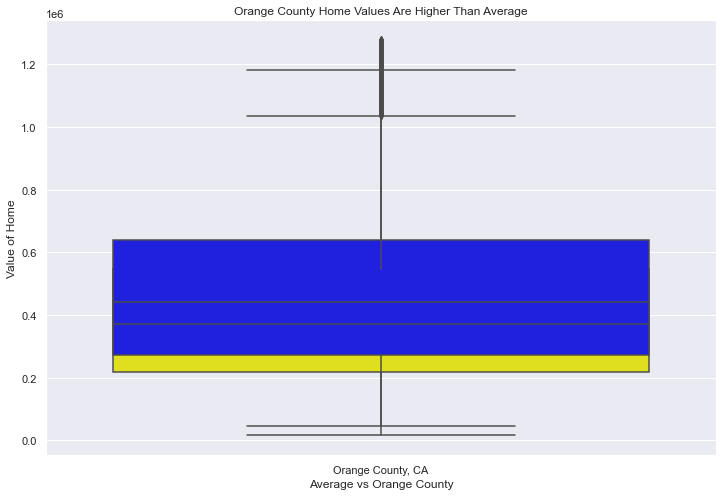

In [10]:
df['one'] = 'one'
sns.boxplot(x=df.one, y=df.Worth, color='yellow')
sns.boxplot(data=df[df.LocalityCode == 'Orange County, CA'], x='LocalityCode', y='Worth', color='blue')
plt.title('Orange County Home Values Are Higher Than Average')
plt.xlabel('Average vs Orange County')
plt.ylabel('Value of Home')
plt.show()

### Post-MVP Hypothesis #2:
The values of Age before the interquartile rule is applied is statistically significantly different from the values of Age after the interquartile rule is applied.

In [11]:
# Mannwhitney test to determine if pre-interquartile rule Age is
# statistically different from post-interquartile rule Age

alpha = .05 / 2
k = 1.5 # Interquartile rule value
col_list = ['Age']
df_test = prep.remove_outliers(df=df, k=k, col_list=col_list)
t, p = stats.mannwhitneyu(df.Age, df_test.Age)

significant(alpha=alpha, truth=(t != 0), p=p)

Hypothesis did not pass 95% confidence threshold


# Modeling
## 1. Initial Setup

In [12]:
df, X_train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test = prep.wrangle_zillow_2()

In [13]:
# Select best features
rfe = RFE(estimator=LinearRegression(), n_features_to_select=5)
rfe.fit(X_train, y_train)
print(list(X_train_exp.columns[-7:][rfe.get_support()]))
rfe.ranking_

['Baths_scaled', 'Beds_scaled', 'LotSize_scaled', 'FinishedSize_scaled', 'LocalityCode_Orange County, CA_scaled']


array([1, 1, 1, 1, 2, 1, 3])

**Note**: I used all of these features. Using all of the above features in the model raised overall model performance.

In [14]:
# Prepare for modeling
y_train = pd.DataFrame(y_train).rename(columns={'Worth':'actuals'})
y_validate = pd.DataFrame(y_validate).rename(columns={'Worth':'actuals'})
y_test = pd.DataFrame(y_test).rename(columns={'Worth':'actuals'})
y_train.shape, y_validate.shape, y_test.shape

((11778, 1), (3926, 1), (3927, 1))

## 2. Model Creation

In [15]:
# Generate predictions from multiple models with varying hyperparameters
# EX: glm_p3a0.1_preds is TweedieRegressor(power=3, alpha=0.1)
y_train, y_validate = modeling.regression_shotgun(X_train, y_train, X_validate, y_validate)
y_train.head(3)

,actuals,mean_bl,median_bl,ols_preds,lars_0.0001_preds,lars_0.001_preds,lars_0.01_preds,lars_0.1_preds,lars_1_preds,lars_10_preds,...,glm_p3a0.1_preds,glm_p3a1_preds,glm_p3a10_preds,glm_p3a100_preds,glm_p3a1000_preds,lm_pf_2_preds,lm_pf_3_preds,lm_pf_4_preds,lm_pf_5_preds,lm_pf_6_preds
5954,496455.0,404497.205807,370000.0,589774.114633,589774.110110,589774.069398,589773.662276,589769.591062,589728.878922,589321.757520,...,404497.205807,404497.205807,404497.205807,404497.205807,404497.205807,701440.0,773632.0,640704.0,725616.0,739712.0
13278,970538.0,404497.205807,370000.0,516519.116492,516519.115240,516519.103980,516518.991372,516517.865296,516506.604533,516393.996909,...,404497.205807,404497.205807,404497.205807,404497.205807,404497.205807,515840.0,511232.0,492864.0,513232.0,475904.0
8087,703469.0,404497.205807,370000.0,475902.944251,475902.861626,475902.118000,475894.681739,475820.319132,475076.693060,467640.432339,...,404497.205807,404497.205807,404497.205807,404497.205807,404497.205807,380416.0,368640.0,389760.0,417008.0,441792.0


In [16]:
# Chunk all predictions into a RMSE and r^2 score calculator
running_df = modeling.y_df_RMSE_r2(y_train, y_validate)
running_df

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
0,mean_bl,248461.414958,247395.157433,0.000000,0.000000
1,median_bl,250844.836366,249934.105116,-0.019277,-0.020631
2,ols_preds,221726.873707,222563.503319,0.203623,0.190670
3,lars_0.0001_preds,221726.873707,222563.503807,0.203623,0.190670
4,lars_0.001_preds,221726.873708,222563.508196,0.203623,0.190670
5,lars_0.01_preds,221726.873752,222563.552135,0.203623,0.190670
6,lars_0.1_preds,221726.878172,222563.995534,0.203623,0.190667
7,lars_1_preds,221727.320141,222568.831317,0.203620,0.190631
8,lars_10_preds,221771.512674,222657.354797,0.203302,0.189988
9,lars_100_preds,223643.854578,224569.950203,0.189793,0.176012


## 3. Model Selection

In [17]:
# PolynomialRegressor(degree=3) had best validate_r2 score, better overall than baseline
mask = (running_df.Model == 'lm_pf_3_preds') | (running_df.Model == 'mean_bl')
running_df[mask]

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
0,mean_bl,248461.414958,247395.157433,0.000000,0.000000
44,lm_pf_3_preds,215177.987132,218297.670418,0.249971,0.221397


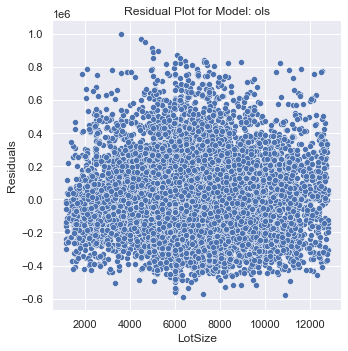

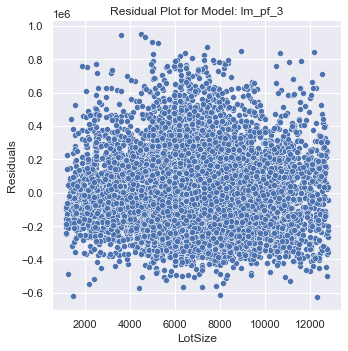

In [18]:
# Too many plots, not enough use; Feel free to adjust which models are plotted
modeling.plot_residuals(X_train_exp.LotSize, y_train[['actuals','ols_preds','lm_pf_3_preds']])

### Running Model on Test Split

In [19]:
y_train, y_test = modeling.pf_lm_predictor(X_train, y_train[['actuals']], X_test, y_test[['actuals']])
running_df = modeling.y_df_RMSE_r2(y_train, y_test)
running_df = running_df.rename(columns={'Validate_RMSE':'Test_RMSE','Validate_r2':'Test_r2'})
running_df[running_df.Model == 'lm_pf_3_preds']

,Model,Train_RMSE,Test_RMSE,Train_r2,Test_r2
1,lm_pf_3_preds,215177.987132,213153.549512,0.249971,0.227796


# 4. Value Drivers

In [20]:
df.head(3)

,ID,DateSold,Worth,TaxRate,Baths,Beds,LotSize,FinishedSize,Age,"LocalityCode_Orange County, CA","LocalityCode_Ventura County, CA"
0,11721753,2017-07-21,205123.0,1.281,2.0,3.0,5672.0,1316.0,94.0,0,0
3,14269464,2017-06-01,880456.0,1.115,3.0,4.0,4975.0,2541.0,14.0,1,0
4,11446756,2017-08-23,107110.0,1.306,2.0,3.0,5000.0,1491.0,62.0,0,0


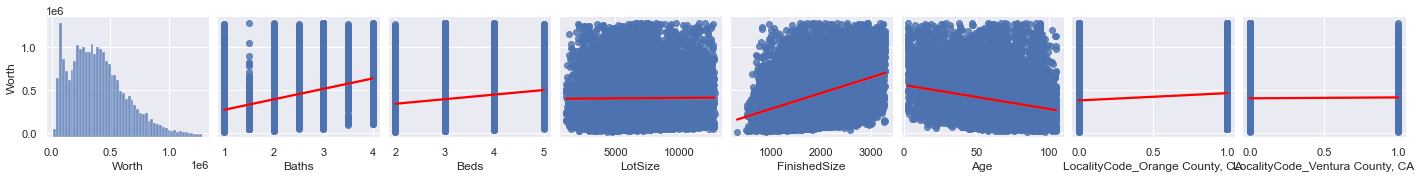

In [21]:
explo = df.copy().drop(columns=['ID','DateSold','TaxRate'])
pairplot = sns.pairplot(explo, y_vars='Worth', kind="reg", plot_kws={'line_kws':{'color':'red'}})

Takeaways from pairplot:
1. FinishedSize and Baths have positive linear regression line against Worth.
2. Age has negative linear regression line against Worth.

## Increasing Number of Bathrooms Increases Value of Home

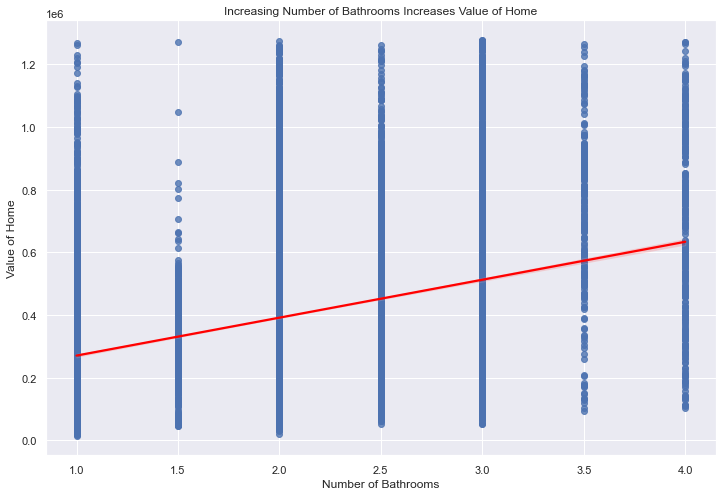

In [22]:
sns.regplot(explo.Baths, explo.Worth, line_kws={'color':'red'})
plt.title('Increasing Number of Bathrooms Increases Value of Home')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Value of Home')
plt.show()

## Increasing Size of Finished Areas Increases Value of Home

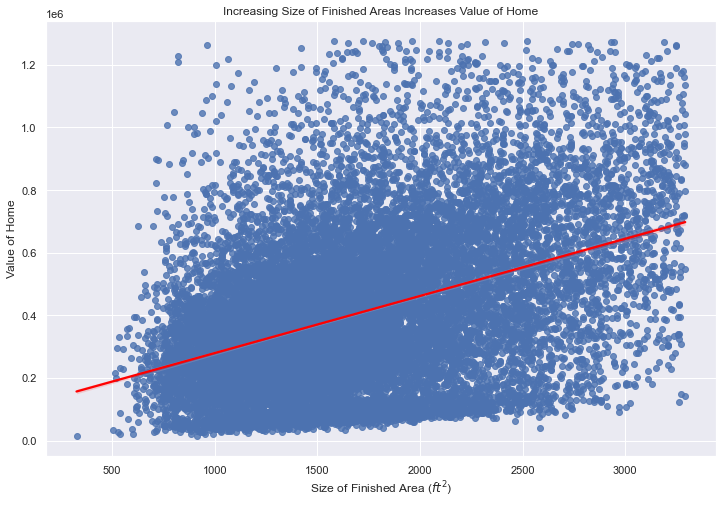

In [23]:
sns.regplot(explo.FinishedSize, explo.Worth, line_kws={'color':'red'})
plt.title('Increasing Size of Finished Areas Increases Value of Home')
plt.xlabel('Size of Finished Area ($ft^2$)')
plt.ylabel('Value of Home')
plt.show()

## Older Homes Are Worth Less Than Newer Ones

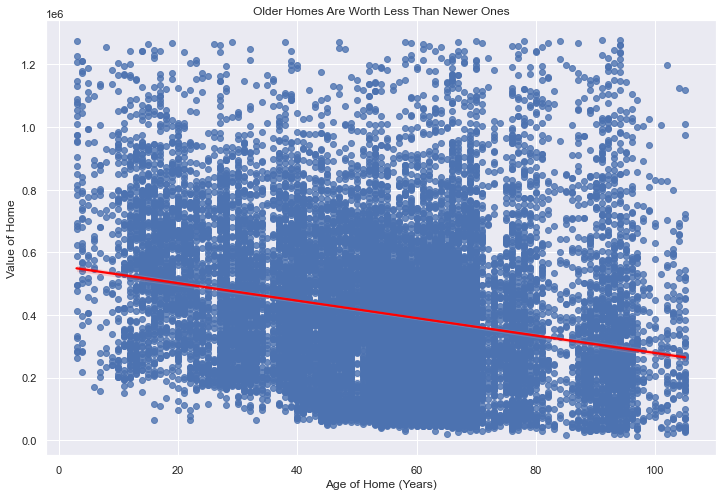

In [24]:
sns.regplot(explo.Age, explo.Worth, line_kws={'color':'red'})
plt.title('Older Homes Are Worth Less Than Newer Ones')
plt.xlabel('Age of Home (Years)')
plt.ylabel('Value of Home')
plt.show()